In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import os
import sys

notebook_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(notebook_dir, '..'))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)
print(sys.path)

%reload_ext autoreload
%autoreload 2

['/Users/ben/Documents/work/research projects/code/hdiva', '/Users/ben/.pyenv/versions/3.10.18/lib/python310.zip', '/Users/ben/.pyenv/versions/3.10.18/lib/python3.10', '/Users/ben/.pyenv/versions/3.10.18/lib/python3.10/lib-dynload', '', '/Users/ben/.pyenv/versions/pyenv-310/lib/python3.10/site-packages']


# assessing the marginal dists of the dataset
extract cx, cy coordinates and get avg background intensity by removing the circle portion from the image. 

In [16]:
from utils.disks import create_one_circle_fractional_1, create_one_circle_fractional_2

# dataset of uniformly sampled variables
c_min = 11
c_max = 21
n_samples = int(25e4)
cxs = c_min + np.random.rand(n_samples) * (c_max - c_min)
cys = c_min + np.random.rand(n_samples) * (c_max - c_min)

random_disks = torch.ones(n_samples, 1, 32, 32) * torch.nan
dataset_cxs = torch.ones(n_samples) * torch.nan
dataset_cys = torch.ones(n_samples) * torch.nan
dataset_bkgs = torch.ones(n_samples) * torch.nan
for i, (cx, cy) in enumerate(zip(cxs, cys)):
    random_disk, cx, cy, background = create_one_circle_fractional_2(c_x=cx, c_y=cy)
    random_disks[i] = random_disk
    dataset_cxs[i] = cx
    dataset_cys[i] = cy
    dataset_bkgs[i] = background
print(random_disks.shape)

torch.Size([250000, 1, 32, 32])


[Text(0.5, 1.0, 'background')]

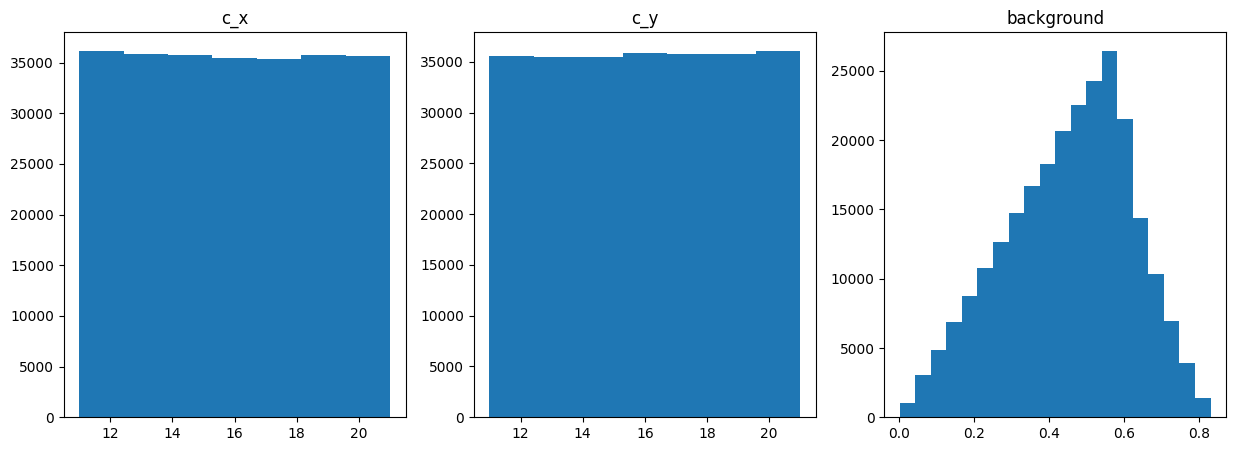

In [17]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
n_bins = 7
ax[0].hist(dataset_cxs, bins=n_bins)
ax[0].set(title="c_x")
ax[1].hist(dataset_cys, bins=n_bins)
ax[1].set(title="c_y")
ax[2].hist(dataset_bkgs, bins=20)
ax[2].set(title="background")

## get variables for one image

Center of the circle: (np.float32(11.9), np.float32(18.9))
average background intensity is: 0.5367


[Text(0.5, 1.0, 'Foreground mask')]

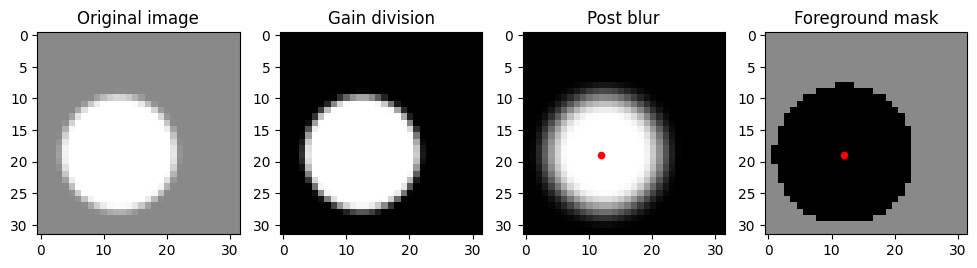

In [16]:
img = random_disks[6][0].numpy()

from utils.disk_analysis import infer_disk_statistics
center, avg_i_bkg, img_gain, img_blur, masked_img = infer_disk_statistics(img)
print(f"Center of the circle: {center}")
print(f'average background intensity is: {avg_i_bkg:.4f}')

# plot transformation
fig, ax = plt.subplots(1, 4, figsize=(12, 5))
ax[0].imshow(img, cmap="gray", vmin=0, vmax=1)
ax[0].set(title="Original image")

ax[1].imshow(img_gain, cmap="gray", vmin=0, vmax=255)
ax[1].set(title="Gain division")

ax[2].imshow(img_blur, cmap="gray", vmin=0, vmax=255)
ax[2].set(title="Post blur")
if center:
    ax[2].scatter(center[0], center[1], c='r', s=20)

ax[3].imshow(masked_img[0], cmap="gray", vmin=0, vmax=1)
ax[3].scatter(center[0], center[1], c='r', s=20)
ax[3].set(title="Foreground mask")


## measure statistics for dataset

In [23]:
num_images = random_disks.shape[0]

inferred_dataset_cxs = np.ones(num_images) * np.nan
inferred_dataset_cys = np.ones(num_images) * np.nan
inferred_dataset_ibkgs = np.ones(num_images) * np.nan
for i in range(num_images):
    center, avg_i_bkg, _, _, _ = infer_disk_statistics(random_disks[i][0].numpy())

    inferred_dataset_cxs[i] = center[0]
    inferred_dataset_cys[i] = center[1]
    inferred_dataset_ibkgs[i] = avg_i_bkg

[Text(0.5, 1.0, 'Average background intensity')]

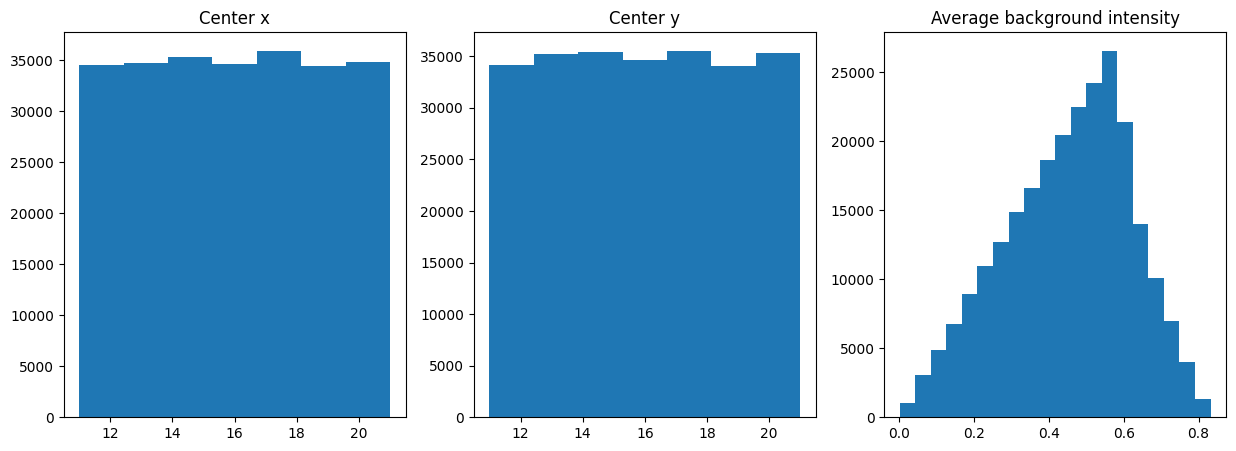

In [19]:
# histogram
n_bins = 8
c_bins = np.linspace(11, 21, n_bins)
# b_bins = np.linspace(0, 1, n_bins)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].hist(inferred_dataset_cxs, bins=c_bins)
ax[0].set(title="Center x")

ax[1].hist(inferred_dataset_cys, bins=c_bins)
ax[1].set(title="Center y")

ax[2].hist(inferred_dataset_ibkgs, bins=20)
ax[2].set(title="Average background intensity")

# structured (cone) disk dataset

I want the generative factors to be dependent on another factor. 

For example, $c_x$ and $c_y$ are dependent on $I_\text{bkg}$ via the equation: 
$$
c_x^2 + c_y^2 = I_\text{bkg}^2 / \sqrt{2}
$$

Where the top and bottom of the image has $c_x=1, c_y=-1$ respectively. $I_\text{bkg}$ can go from 0 to 1.

In [ ]:
from utils.disks import create_one_circle_fractional_1, create_one_circle_fractional_2
n_interpolations = 5
cxs = np.linspace(11, 21, n_interpolations)
cys = np.linspace(11, 21, n_interpolations)

disks_1 = []
disks_2 = []
for cx in cxs:
    for cy in cys:
        disk_1 = create_one_circle_fractional_1(c_x = cx, c_y=cy)[0]
        disk_2 = create_one_circle_fractional_2(c_x = cx, c_y=cy)[0]
        disks_1.append(disk_1)
        disks_2.append(disk_2)
disks_1 = torch.stack(disks_1)
disks_2 = torch.stack(disks_2)

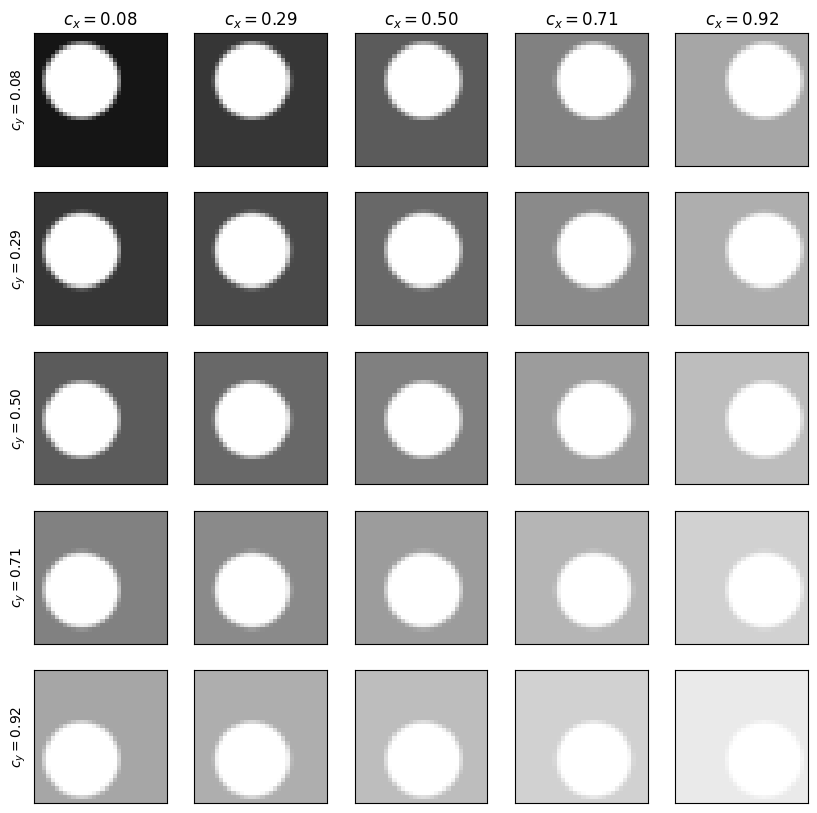

In [ ]:
fig, ax = plt.subplots(5, 5, figsize=(10, 10))
for i in range(5):
    for j in range(5):
        ax[i, j].imshow(disks_1[5*j+i][0], cmap="gray", vmin=0, vmax=1)
        ax[i, j].set(xticks=[], yticks=[])
for i in range(5):
    c_x = cxs[i]
    c_y = cys[i]
    c_min = 10
    c_max = 22
    cx = (c_x - c_min)/(c_max-c_min)
    cy = (c_y - c_min)/(c_max-c_min)
    ax[0, i].set(title=f"$c_x={cx:.2f}$")
    ax[i, 0].set(ylabel=f"$c_y={cy:.2f}$")

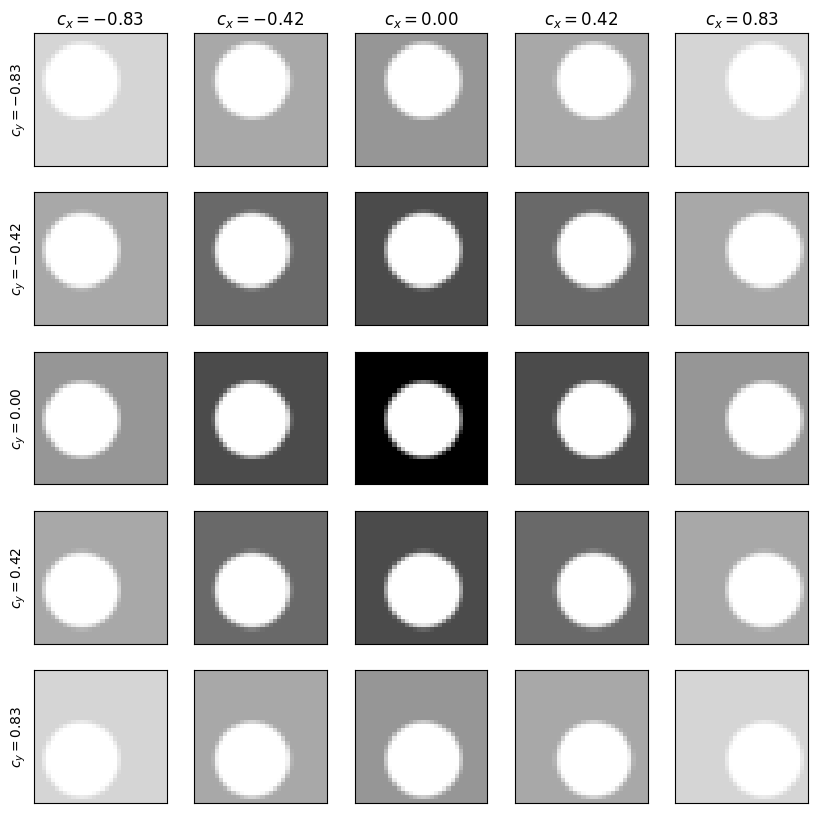

In [ ]:
fig, ax = plt.subplots(5, 5, figsize=(10, 10))
for i in range(5):
    for j in range(5):
        ax[i, j].imshow(disks_2[5*j+i][0], cmap="gray", vmin=0, vmax=1)
        ax[i, j].set(xticks=[], yticks=[])
for i in range(5):
    c_x = cxs[i]
    c_y = cys[i]
    c_min = 10
    c_max = 22
    cx = (c_x - c_min)/(c_max-c_min) * 2 - 1
    cy = (c_y - c_min)/(c_max-c_min) * 2 - 1
    ax[0, i].set(title=f"$c_x={cx:.2f}$")
    ax[i, 0].set(ylabel=f"$c_y={cy:.2f}$")

# hierarchical dataset

here we're going to have two disks with different intensities.

(np.float64(-0.5), np.float64(63.5), np.float64(63.5), np.float64(-0.5))

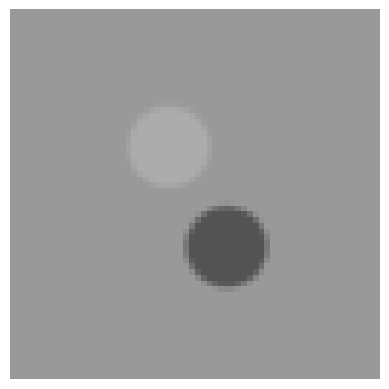

In [3]:
from utils.disks import create_two_disk_img_using_global_vars

img = create_two_disk_img_using_global_vars(
    img_size=64, outer_radius=8, transition_width=2, d=20,
    theta=np.pi/6, delta_id=0.2, ib=.6, cx_01=.5, cy_01=.5)[0]

fig, ax = plt.subplots(1, 1)
ax.imshow(img[0], cmap="gray", vmin=0, vmax=1)
ax.axis("off")

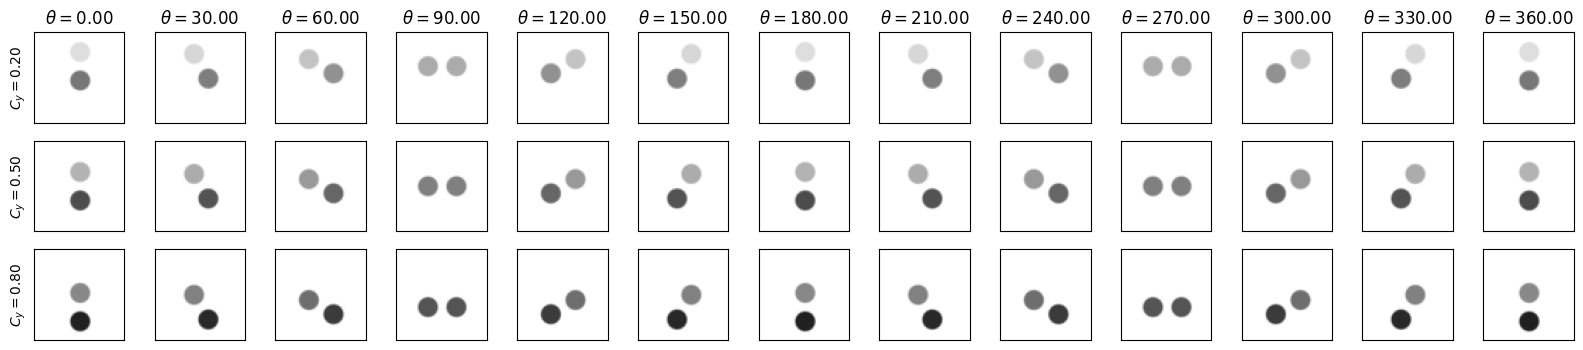

In [4]:
n_interpolations = 13
cys = [0.2, .5, .8]
n_cys = len(cys)
ib = 1.
thetas = np.linspace(0, np.pi * 2, n_interpolations)

disks = torch.empty((n_cys, n_interpolations, 1, 64, 64))


for i, cy in enumerate(cys):
    for j, theta in enumerate(thetas):
        disks[i, j] = create_two_disk_img_using_global_vars(
            img_size=64, outer_radius=8, transition_width=2, d=20,
            theta=theta, delta_id=0.2, ib=ib, cx_01=.5, cy_01=cy)[0]


fig, ax = plt.subplots(n_cys, n_interpolations, figsize=(20, 4))
for i in range(n_cys):
    for j in range(n_interpolations):
        ax[i, j].imshow(disks[i, j, 0], cmap="gray", vmin=0, vmax=1)
        ax[i, j].set(xticks=[], yticks=[])

for j in range(n_interpolations):
    theta = thetas[j] / np.pi * 180  # convert to degrees
    ax[0, j].set(title=f"$\\theta={theta:.2f}$")

for i in range(n_cys):
    ax[i, 0].set(ylabel=f"$C_y={cys[i]:.2f}$")

[Text(0.5, 0, 'orientation (degrees)'), Text(0, 0.5, 'Disk intensity')]

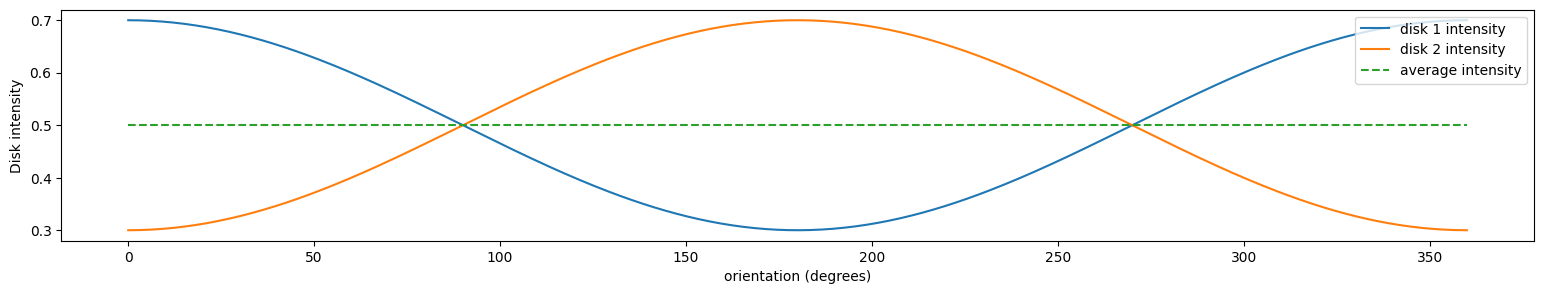

In [5]:
n_interpolations = 360
thetas = np.linspace(0, np.pi * 2, n_interpolations)
ids = torch.empty((n_interpolations, 3))

i = 0
for theta in thetas:
    (avg_id, id1, id2) = create_two_disk_img_using_global_vars(
        img_size=64, outer_radius=8, transition_width=2, d=20,
        theta=theta, delta_id=0.2, ib=1, cx_01=.5, cy_01=.5)[1:4]
    ids[i][0] = id1
    ids[i][1] = id2 
    ids[i][2] = avg_id  # store average intensity
    i += 1

fig, ax = plt.subplots(1, 1, figsize=(19, 3))
ax.plot(thetas /np.pi * 180, ids[:,0], label='disk 1 intensity')
ax.plot(thetas /np.pi * 180, ids[:,1], label='disk 2 intensity')
ax.plot(thetas /np.pi * 180, ids[:,2], '--', label='average intensity')
ax.legend()
ax.set(xlabel='orientation (degrees)', ylabel='Disk intensity')

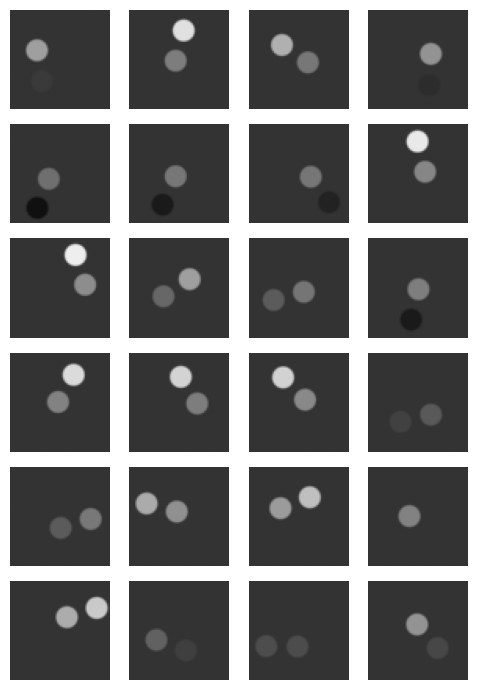

In [6]:
from utils.disks import random_two_disk_dataset
# random sample of disks
dataset = random_two_disk_dataset(
    delta_id=.2,
    d=20, outer_radius=8, transition_width=2,
    img_size=64, num_imgs=24,
    ib=0.2
)

fig, ax = plt.subplots(6, 4, figsize=(5, 7))
for i in range(6):
    for j in range(4):
        ax[i, j].imshow(dataset[i * 4 + j][0], cmap="gray", vmin=0, vmax=1)
        ax[i, j].axis("off")
fig.tight_layout()

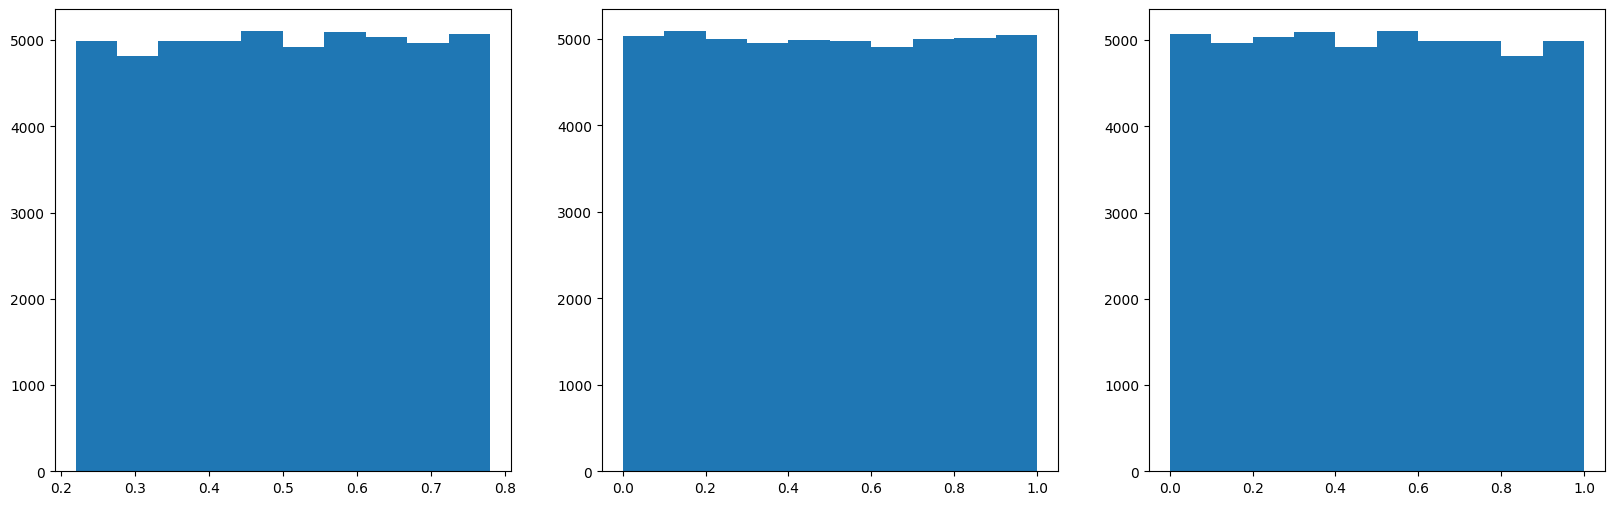

In [18]:
# see how many image samples we need to get a good approximation of the gt factor distributions
from utils.disks import random_two_disk_dataset

# random sample of disks
num_imgs = 5e4
dataset, avg_intensities, cxs, cys, thetas = random_two_disk_dataset(
    delta_id=.2,
    d=20, outer_radius=8, transition_width=2,
    img_size=64, num_imgs=num_imgs,
    ib=0.2
)

fig, ax = plt.subplots(1, 3, figsize=(20, 6))
ax[0].hist(avg_intensities, bins=10);
ax[1].hist(cxs, bins=10);
ax[2].hist(cys, bins=10);

# smaller

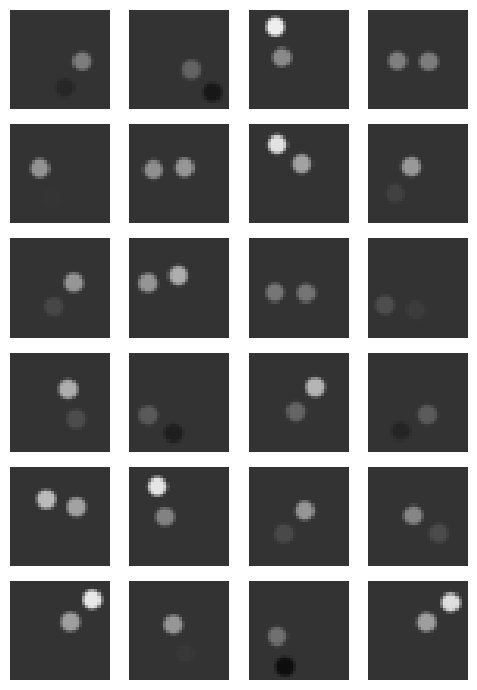

In [20]:
from utils.disks import random_two_disk_dataset
# random sample of disks
dataset = random_two_disk_dataset(
    delta_id=.2,
    d=10, outer_radius=4, transition_width=2,
    img_size=32, num_imgs=24,
    ib=0.2
)[0]

fig, ax = plt.subplots(6, 4, figsize=(5, 7))
for i in range(6):
    for j in range(4):
        ax[i, j].imshow(dataset[i * 4 + j][0], cmap="gray", vmin=0, vmax=1)
        ax[i, j].axis("off")
fig.tight_layout()